# grid search for hyperparatemer C in LG3 

validation testing as part of training data (CJP)---for evaluate the C performance

In [1]:
import gzip
import pandas as pd
import numpy as np
from joblib import dump, load

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

/Users/nancy/miniconda3/envs/bioinfo/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## get traring dataset: CJP

In [4]:
# get train data: clin just newpatho
df_train_merge=pd.read_csv('/Users/nancy/Desktop/RS_projects/data/04_ML_modify/01_retrainModel_ClinvarJusthuskyNewpatho/01_train_merge_ClinvarJustPatho_add29features.csv')
df_train_merge

,CLNSIG,CADD,AF_TGP,Frq,IMPACT,GNOMADAF_popmax,Hom,ORIGIN,SPIDEX,SWEGENAF,...,GERP++_RS,REVEL_score,phastCons100way_vertebrate,phyloP100way_vertebrate,LoFtool,pLI_gene_value,SpliceAI_pred_DS_AG,SpliceAI_pred_DS_AL,SpliceAI_pred_DS_DG,SpliceAI_pred_DS_DL
0,Uncertain_significance,26.60,NaN,NaN,MODERATE,NaN,NaN,1.0,1.763,NaN,...,3.600,0.347,1.000,7.343,NaN,0.00,0.01,0.00,0.09,0.00
1,Likely_benign,13.42,NaN,NaN,LOW,NaN,NaN,1.0,-1.030,NaN,...,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.02,0.03,0.00
2,Likely_benign,31.00,NaN,0.00056,MODERATE,0.000195,NaN,1.0,-0.910,NaN,...,4.520,0.429,1.000,5.538,NaN,0.00,0.00,0.01,0.06,0.00
3,Uncertain_significance,28.20,NaN,NaN,MODERATE,NaN,NaN,1.0,0.814,NaN,...,4.520,0.458,1.000,3.691,NaN,0.00,0.00,0.00,0.03,0.02
4,Likely_benign,11.38,NaN,NaN,LOW,NaN,NaN,1.0,0.992,NaN,...,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.01,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3757032,Pathogenic,25.40,NaN,NaN,MODERATE,NaN,NaN,NaN,-1.648,NaN,...,3.050,0.716,1.000,7.489,0.151,1.00,0.00,0.00,0.00,0.00
3757033,Pathogenic,21.30,NaN,0.00140,MODERATE,NaN,NaN,NaN,NaN,0.0005,...,1.560,0.219,0.009,0.707,NaN,0.18,0.03,0.00,0.00,0.00
3757034,Pathogenic,24.00,NaN,0.00014,MODERATE,NaN,NaN,NaN,NaN,NaN,...,5.290,0.287,0.998,3.589,0.739,0.00,0.00,0.00,0.00,0.00
3757035,Pathogenic,16.88,NaN,0.00350,MODERATE,0.001555,NaN,NaN,-1.149,0.0015,...,1.440,0.025,0.320,0.737,0.143,0.94,0.00,0.00,0.00,0.00


In [5]:
""" 1. choose featuresV1"""

featureV1 = ['CLNSIG',
'CADD',
'Frq',
'GNOMADAF_popmax',
'Consequence',
'BIOTYPE',
'PolyPhen',
'REVEL_score',
'pLI_gene_value',
'SpliceAI_pred_DS_AG',
'SpliceAI_pred_DS_AL',
'SpliceAI_pred_DS_DG',
'SpliceAI_pred_DS_DL']         # keep CLNSIG,

df_1 = df_train_merge[featureV1]



""" 2. only remove missing target """

drop_nan_features = ['CLNSIG']

df_1 = df_1.dropna(subset=drop_nan_features)

df_1 

""" 3. deal with target feature """
# """  CLNSIG: tansfer to 4 classes__ benign,pathogenic,uncertain,others
# NOTE:
# (only count name before |)   explanation-- https://www.ncbi.nlm.nih.gov/clinvar/docs/clinsig/#clinsig_scv

# 1. pathogenic: Pathogenic, Pathogenic/Likely_pathogenic, Likely_pathogenic
# 2. benign: Likely_benign, Benign, Benign/Likely_benign
# 3. uncertain: Uncertain_significance, 
# 4. others: Uncertain_risk_allele, risk_factor, protective, other, not_provided, Likely_risk_allele, drug_response, Conflicting_interpretations_of_pathogenicity, confers_sensitivity, associatio, Affects

df_1 = df_1.copy()
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Uncertain_significance|_risk_factor', 'Uncertain_significance|_other', 'Uncertain_significance|_drug_response','Uncertain_significance|_association','Uncertain_significance|_Affects','Uncertain_significance'], 'uncertain')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Pathogenic|_risk_factor','Pathogenic|_protective','Pathogenic|_other','Pathogenic|_drug_response|_other','Pathogenic|_drug_response','Pathogenic|_confers_sensitivity','Pathogenic|_association','Pathogenic|_Affects','Pathogenic/Likely_risk_allele','Pathogenic/Likely_pathogenic|_risk_factor','Pathogenic/Likely_pathogenic|_other','Pathogenic/Likely_pathogenic|_drug_response','Pathogenic/Likely_pathogenic','Pathogenic','Likely_pathogenic|_risk_factor','Likely_pathogenic|_other','Likely_pathogenic|_drug_response','Likely_pathogenic|_association','Likely_pathogenic|_Affects','Likely_pathogenic,_low_penetrance','Likely_pathogenic'], 'pathogenic')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Likely_benign|_risk_factor','Likely_benign|_other','Likely_benign|_drug_response|_other','Likely_benign','Benign|_risk_factor','Benign|_protective','Benign|_other','Benign|_drug_response','Benign|_confers_sensitivity','Benign|_association|_confers_sensitivity','Benign|_association','Benign/Likely_benign|_risk_factor','Benign/Likely_benign|_other|_risk_factor','Benign/Likely_benign|_other','Benign/Likely_benign|_drug_response|_other','Benign/Likely_benign|_drug_response','Benign/Likely_benign|_association','Benign/Likely_benign','Benign'], 'benign')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Uncertain_risk_allele|_risk_factor','Uncertain_risk_allele','risk_factor','protective','protective|_risk_factor','other', 'not_provided','Likely_risk_allele','drug_response|_risk_factor','drug_response|_other','drug_response','Conflicting_interpretations_of_pathogenicity|_risk_factor','Conflicting_interpretations_of_pathogenicity|_protective','Conflicting_interpretations_of_pathogenicity|_other|_risk_factor','Conflicting_interpretations_of_pathogenicity|_other','Conflicting_interpretations_of_pathogenicity|_drug_response|_other','Conflicting_interpretations_of_pathogenicity|_drug_response','Conflicting_interpretations_of_pathogenicity|_association|_risk_factor','Conflicting_interpretations_of_pathogenicity|_association','Conflicting_interpretations_of_pathogenicity','confers_sensitivity','association|_risk_factor','association_not_found','association','Affects|_risk_factor','Affects|_association','Affects'], 'others')

# only keep benign & pathogenic
df_1 = df_1.loc[df_1['CLNSIG'].isin(['benign','pathogenic'])]

# label encoder
map_clnsig={'pathogenic':1,'benign':0}
df_1['CLNSIG']=df_1['CLNSIG'].map(lambda s: map_clnsig.get(s) if s in map_clnsig else s)
df_1["CLNSIG"].unique()


"""4.2  keep imbalance classes """

# split

X, y = df_1.iloc[:, 1:], df_1.iloc[:, 0]
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                    test_size=0.3,
                    random_state=42,
                    stratify=y)


## get previous fitted preprocessor3, but LG model need to train here, 
since we use cross-validation with different C in the train

In [2]:
preprocessor = load('/Users/nancy/Desktop/RS_projects/result/04_ML_modify/01_retrainModel_ClinvarJusthuskyNewpatho/models/02_12feats_ClinJustPatho5-5_preprocessor.joblib')

## Main hyperparameter,  grid search:  might choose C = 10 for now
use validation data, not test data
LG :  C

    smaller C  ---ight lead to underfitting

    bigger C   ---might lead to overfitting

E.g. if I’m massively overfitting, try decreasing max_depth or C.

In [6]:
## use X_train and  cross_validate to check the accuracy for test:
# for different C, do n folds stratified validation, and look the mean train and validation score

scores_dict = {
    "C": 10.0 ** np.arange(-4, 6, 1),
    "mean_train_scores": list(),  # train
    "mean_cv_scores": list(),     # validation
}



for C in scores_dict["C"]:
    lr = LogisticRegression(C=C, max_iter=10000, random_state=42)
    pipeline = make_pipeline(preprocessor,lr)    

    scores = cross_validate(pipeline, X_train, y_train, return_train_score=True, cv=2)   # cross_validate is used, not only coz it give validation , also it won't created a real model, no need fit, just give score to measure
         ## the pipeline and croo_validation: automatically fitted by X_train and create cross validation part inside
    
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df


,C,mean_train_scores,mean_cv_scores
0,0.0001,0.992705,0.992712
1,0.0010,0.993265,0.993273
2,0.0100,0.993594,0.993596
3,0.1000,0.993933,0.993919
4,1.0000,0.994203,0.994199
5,10.0000,0.994337,0.994331
6,100.0000,0.994374,0.994372
7,1000.0000,0.994372,0.994373
8,10000.0000,0.994360,0.994357
9,100000.0000,0.994366,0.994363


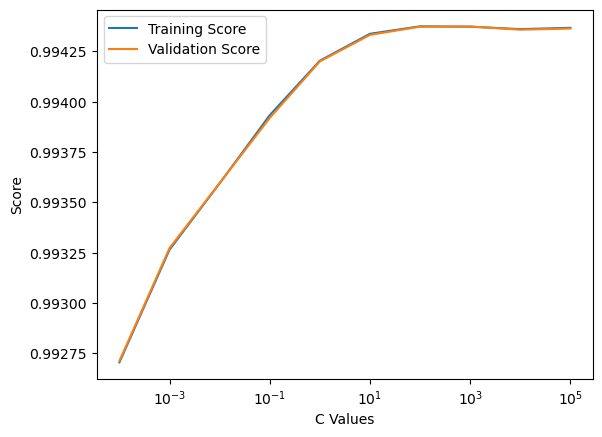

In [10]:
# Create a line semilogx with C values on the x-axis and scores on the y-axis:
### like: C = 10 /100 is best


# Extract the C values, training scores and validation scores from the DataFrame
C_values = results_df['C']
train_scores = results_df['mean_train_scores']
val_scores = results_df['mean_cv_scores']



plt.semilogx(C_values, train_scores, label='Training Score')  # semilogx function uses a logarithmic scale for the X-axis
plt.semilogx(C_values, val_scores, label='Validation Score')
plt.xlabel('C Values')
plt.ylabel('Score')
# plt.title('Grid Search Results')
plt.legend()
plt.show()

2. since the data classes are imbalance , so draw a ROC-curve instead of only accuracy_score

since save time, didn't do cross_validate here (but results should be same)-- ROC need to use test proba

(maybe also can check `Cross validation with different metrics` , but not yet)

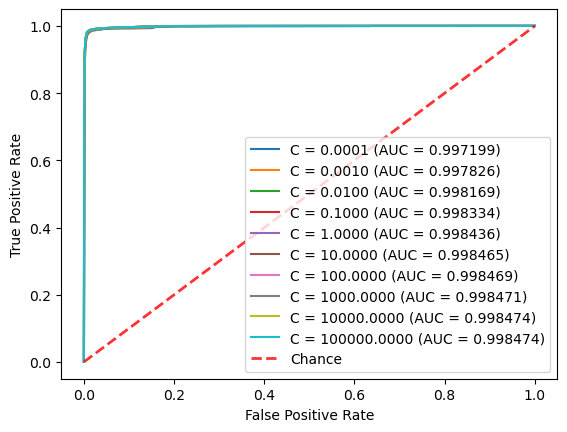

In [12]:
## 
from sklearn.metrics import roc_curve, auc

scores_dict = {
    "C": 10.0 ** np.arange(-4, 6, 1),
    "train_auc": list(),
}

# create an empty list to store the AUC scores
auc_scores = []

# loop through each C value and generate the ROC with AUC curve
for C in scores_dict["C"]:
    lr = LogisticRegression(C=C, max_iter=10000, random_state = 42)
    pipeline = make_pipeline(preprocessor,lr)
    pipeline.fit(X_train,y_train)


    y_score = pipeline.predict_proba(X_test)[:, 1]  # index 1 -- positive: pathogenic
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, label="C = %0.4f (AUC = %0.6f)" % (C, roc_auc))

# plot the ROC curves for all C values in one graph
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()